<a href="https://colab.research.google.com/github/matthew-mcateer/noise-weight-theft/blob/master/qmnist_siamese_one_pixel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np

import random
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.optimizers import RMSprop
from keras import backend as K
%config InlineBackend.figure_format = 'retina'

num_classes = 10
epochs = 20

Using TensorFlow backend.


In [0]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)


def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)


def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(2, activation='linear')(x)
    return Model(input, x)


def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [0]:
%config InlineBackend.figure_format = 'retina'

!wget -q https://github.com/facebookresearch/qmnist/raw/master/qmnist-test-images-idx3-ubyte.gz
!wget -q https://github.com/facebookresearch/qmnist/raw/master/qmnist-test-labels-idx1-ubyte.gz
!wget -q https://github.com/facebookresearch/qmnist/raw/master/qmnist-test-labels-idx2-int.gz
!wget -q https://github.com/facebookresearch/qmnist/raw/master/qmnist-test-labels.tsv.gz
!wget -q https://github.com/facebookresearch/qmnist/raw/master/qmnist-train-images-idx3-ubyte.gz
!wget -q https://github.com/facebookresearch/qmnist/raw/master/qmnist-train-labels-idx2-int.gz
!wget -q https://github.com/facebookresearch/qmnist/raw/master/qmnist-train-labels.tsv.gz
!wget -q https://github.com/facebookresearch/qmnist/raw/master/xnist-images-idx3-ubyte.xz
!wget -q https://github.com/facebookresearch/qmnist/raw/master/xnist-labels-idx2-int.xz
!wget -q https://github.com/facebookresearch/qmnist/raw/master/xnist-labels.tsv.xz

!gunzip qmnist-test-images-idx3-ubyte.gz
!gunzip qmnist-test-labels-idx1-ubyte.gz
!gunzip qmnist-test-labels-idx2-int.gz
!gunzip qmnist-test-labels.tsv.gz
!gunzip qmnist-train-images-idx3-ubyte.gz
!gunzip qmnist-train-labels-idx2-int.gz
!gunzip qmnist-train-labels.tsv.gz

In [0]:
import codecs
import numpy as np
import torch

def get_int(b):
    return int(codecs.encode(b, 'hex'), 16)

def open_maybe_compressed_file(path):
    if path.endswith('.gz'):
        return gzip.open(path, 'rb')
    elif path.endswith('.xz'):
        return lzma.open(path, 'rb')
    else:
        return open(path,'rb')
    
def read_idx2_int(path):
    with open_maybe_compressed_file(path) as f:
        data = f.read()
        assert get_int(data[:4]) == 12*256 + 2
        length = get_int(data[4:8])
        width = get_int(data[8:12])
        parsed = np.frombuffer(data, dtype=np.dtype('>i4'), offset=12)
        return torch.from_numpy(parsed.astype('i4')).view(length,width).long().numpy()

def read_idx3_ubyte(path):
    with open_maybe_compressed_file(path) as f:
        data = f.read()
        assert get_int(data[:4]) == 8 * 256 + 3
        length = get_int(data[4:8])
        num_rows = get_int(data[8:12])
        num_cols = get_int(data[12:16])
        parsed = np.frombuffer(data, dtype=np.uint8, offset=16)
        return torch.from_numpy(parsed).view(length, num_rows, num_cols).numpy()

In [5]:
x_train = read_idx3_ubyte('qmnist-train-images-idx3-ubyte')
y_train = read_idx2_int('qmnist-train-labels-idx2-int')
x_test = read_idx3_ubyte('qmnist-test-images-idx3-ubyte')
y_test = read_idx2_int('qmnist-test-labels-idx2-int')
y_train = y_train[:,0].astype('float32')
y_test = y_test[:,0].astype('float32')

print("x_train: {}, {}, {}".format(x_train.shape, type(x_train), type(x_train[0][0][0])))
print("y_train: {}, {}, {}".format(y_train.shape, type(y_train), type(y_train[0])))
print("x_test:  {}, {}, {}".format(x_test.shape, type(x_test), type(x_test[0][0][0])))
print("y_test:  {}, {}, {}".format(y_test.shape, type(y_test), type(y_test[0])))

x_train: (60000, 28, 28), <class 'numpy.ndarray'>, <class 'numpy.uint8'>
y_train: (60000,), <class 'numpy.ndarray'>, <class 'numpy.float32'>
x_test:  (60000, 28, 28), <class 'numpy.ndarray'>, <class 'numpy.uint8'>
y_test:  (60000,), <class 'numpy.ndarray'>, <class 'numpy.float32'>


In [6]:
# the data, split between train and test sets
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
input_shape = x_train.shape[1:]

# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

# train
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 108400 samples, validate on 109060 samples
Epoch 1/20
108400/108400 [==============================] - 18s 162us/step - loss: 0.1166 - accuracy: 0.8511 - val_loss: 0.0770 - val_accuracy: 0.9159
Epoch 2/20
108400/108400 [==============================] - 8s 70us/step - loss: 0.0751 - accuracy: 0.9195 - val_loss: 0.0633 - val_accuracy: 0.9308
Epoch 3/20
108400/108400 [==============================] - 8s 71us/step - loss: 0.0610 - accuracy: 0.9378 - val_loss: 0.0535 - val_accuracy: 0.9394
Epoch 4/20
108400/108400 [==============================] - 8s 70us/step - loss: 0.0532 - accuracy: 0.9476 - val_loss: 0.0519 - val_accuracy: 0.9444
Epoch 5/20
108400/108400 [==============================] - 8s 72us/step - loss: 0.0480 - accuracy: 0.9553 - val_loss: 0.0485 - val_acc

In [0]:
pixel_batch = []

for i in range(28):
    for j in range(28):
        pix_img = np.zeros_like(x_train[0])
        pix_img[i, j] = 1.0 # Could also try random [0, 1] values
    
        pixel_batch.append(pix_img)
    
pixel_batch = np.stack(pixel_batch)

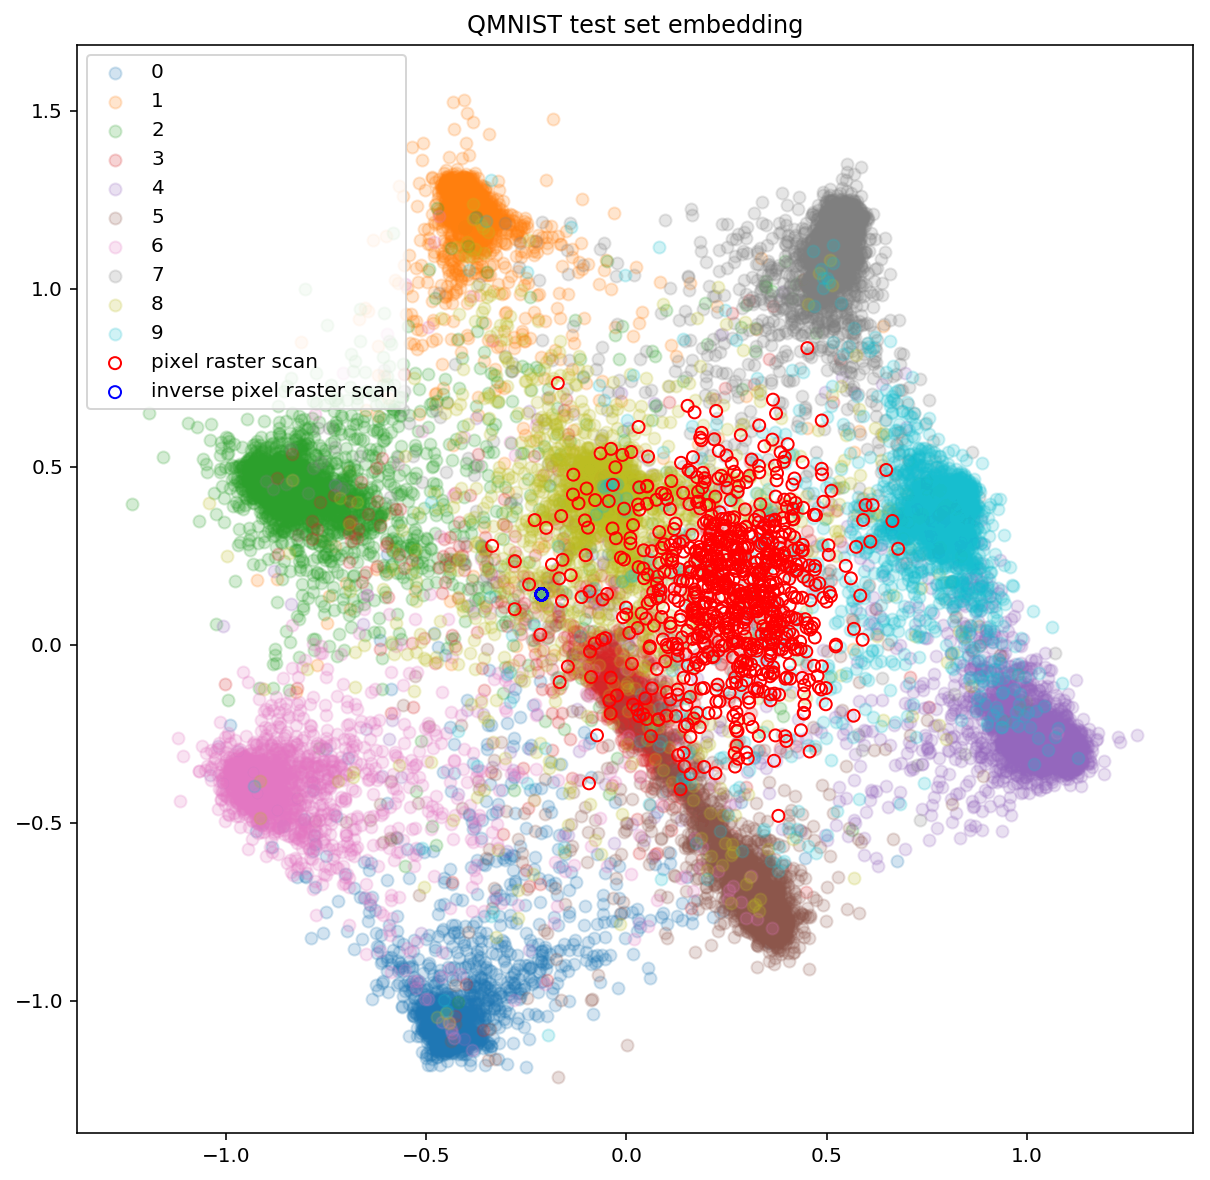

In [8]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'


x_test_emb = base_network.predict(x_test)


plt.figure(figsize=(10, 10))
for i in range(10):
    plt.scatter(x_test_emb[y_test == i][:, 0], 
                x_test_emb[y_test == i][:, 1], 
                label='{}'.format(i), alpha=0.2)


pixel_batch_emb = base_network.predict(pixel_batch)
plt.scatter(pixel_batch_emb[:, 0], 
            pixel_batch_emb[:, 1], 
            label='pixel raster scan', 
            alpha=1.0, 
            color='red', 
            facecolors='none')

pixel_batch_inv_emb = base_network.predict(1.0 - pixel_batch)
plt.scatter(pixel_batch_inv_emb[:, 0], 
            pixel_batch_inv_emb[:, 1], 
            label='inverse pixel raster scan', 
            alpha=1.0, 
            color='blue', 
            facecolors='none')



plt.title("QMNIST test set embedding")
plt.legend()
plt.show()

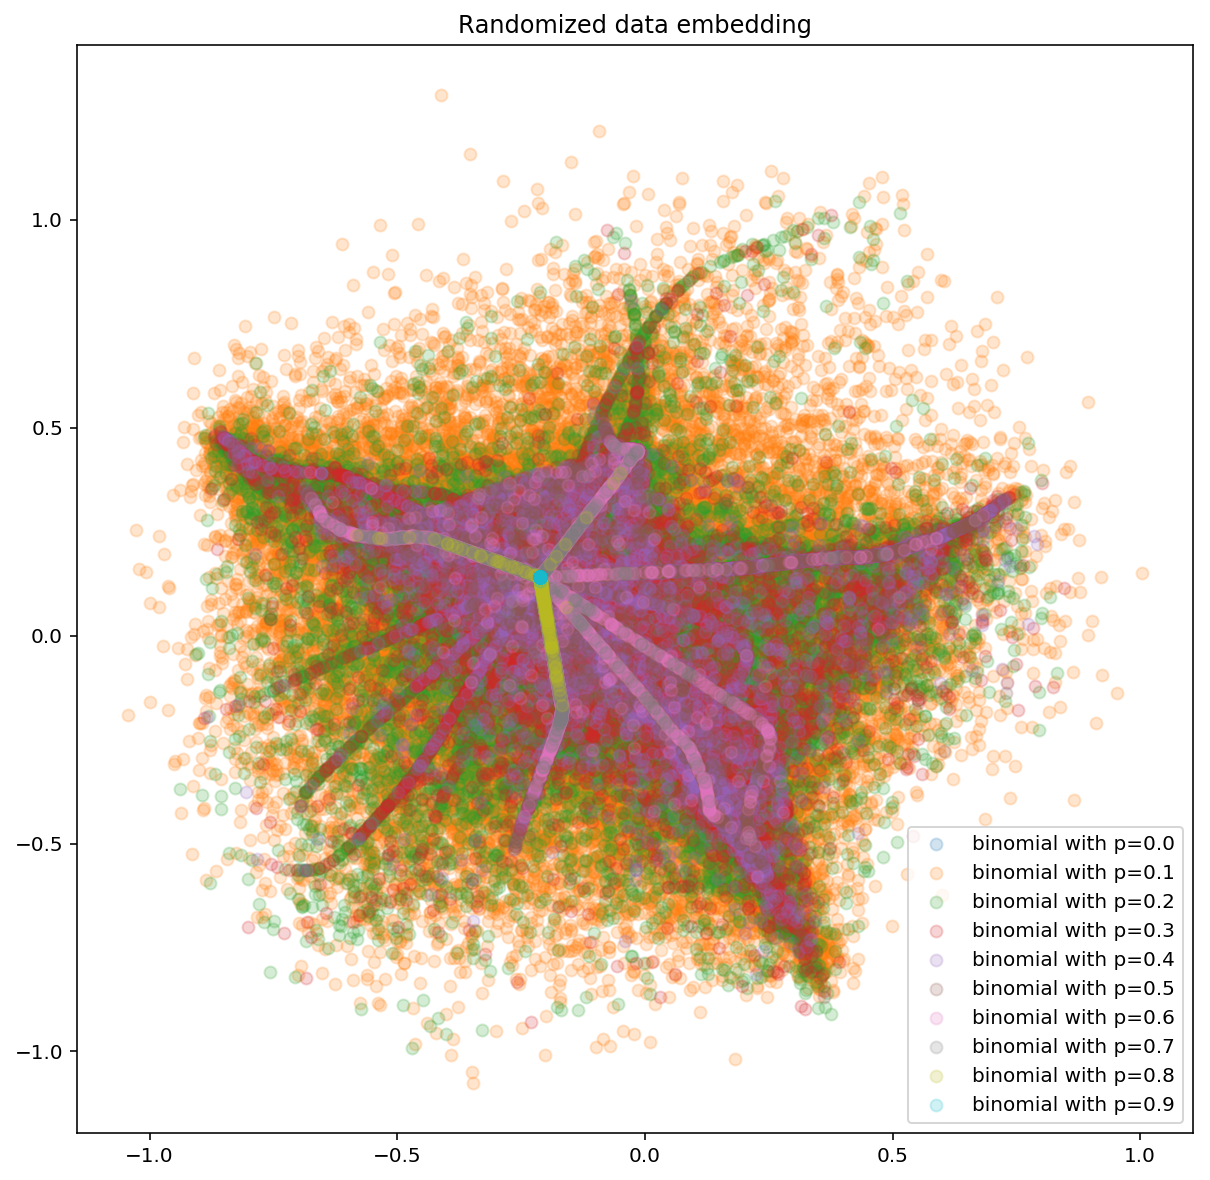

In [9]:
plt.figure(figsize=(10, 10))

x_test_emb = base_network.predict(x_test)

# Generate stimulus response pairs
x_rand = []
y_rand = []
for p in np.arange(0, 1, 0.1):
    x_rand.append(np.random.binomial(1, p, (50000, 28, 28)))
    y_rand.append(base_network.predict(x_rand[-1]))
  
    plt.scatter(y_rand[-1][:, 0], 
                y_rand[-1][:, 1], 
                label='binomial with p={0:0.1f}'.format(p), 
                alpha=0.2)

x_rand = np.vstack(x_rand)
y_rand = np.vstack(y_rand)



plt.title("Randomized data embedding")
plt.legend()
plt.show()

In [10]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = (x_rand, y_rand), (x_test, y_test)

print(x_train.shape)
print(x_test.shape)

x_train = np.expand_dims(x_rand, -1)
x_test = np.expand_dims(x_test, -1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
input_shape = x_train.shape[1:]

# network definition
model_steal = Sequential()
model_steal.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model_steal.add(Conv2D(64, (3, 3), activation='relu'))
model_steal.add(MaxPooling2D(pool_size=(2, 2)))
model_steal.add(Flatten())
model_steal.add(Dense(128, activation='relu'))
model_steal.add(Dense(2, activation='linear'))

model_steal.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['mae', 'mse'])

model_steal.fit(x_train, y_train,
               batch_size=batch_size,
               epochs=10,
               verbose=1)


(500000, 28, 28)
(60000, 28, 28)

Epoch 1/10
500000/500000 [==============================] - 66s 132us/step - loss: 0.0155 - mean_absolute_error: 0.0623 - mean_squared_error: 0.0155
Epoch 2/10
500000/500000 [==============================] - 63s 127us/step - loss: 0.0122 - mean_absolute_error: 0.0537 - mean_squared_error: 0.0122
Epoch 3/10
500000/500000 [==============================] - 63s 127us/step - loss: 0.0111 - mean_absolute_error: 0.0501 - mean_squared_error: 0.0111
Epoch 4/10
500000/500000 [==============================] - 63s 127us/step - loss: 0.0098 - mean_absolute_error: 0.0463 - mean_squared_error: 0.0098
Epoch 5/10
500000/500000 [==============================] - 64s 128us/step - loss: 0.0088 - mean_absolute_error: 0.0431 - mean_squared_error: 0.0088
Epoch 6/10
500000/500000 [==============================] - 63s 127us/step - loss: 0.0079 - mean_absolute_error: 0.0408 - mean_squared_error: 0.0079
Epoch 7/10
500000/500000 [==============================] - 64s 127us/st

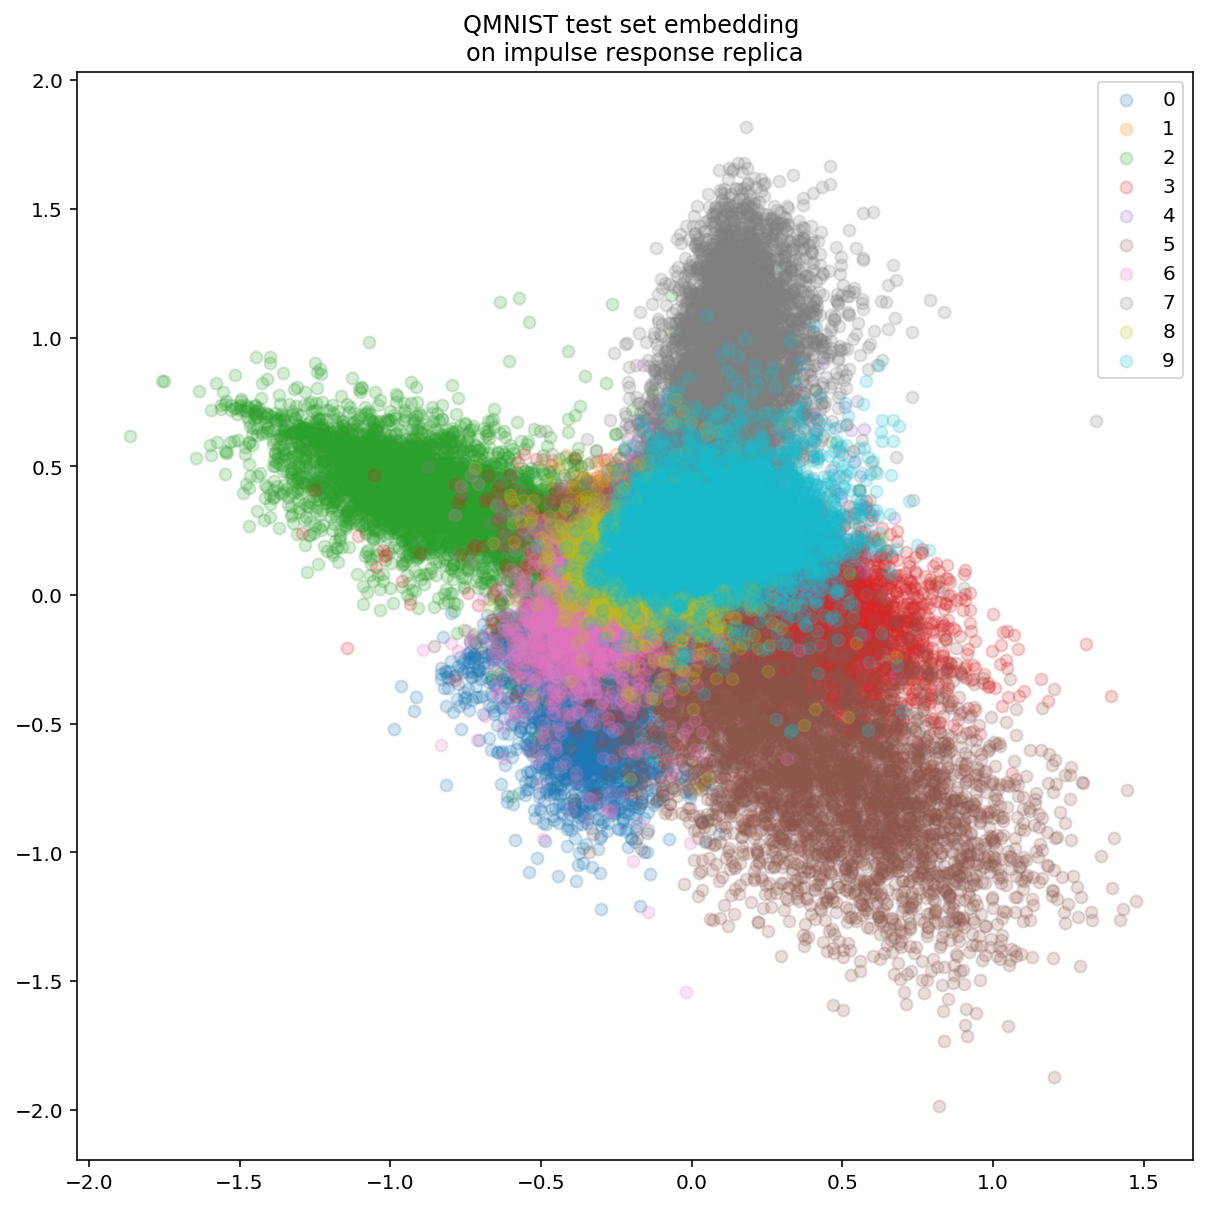

In [11]:
x_test_emb = model_steal.predict(x_test)


plt.figure(figsize=(10, 10))
#plt.xlim(-2.0, 2.0)
#plt.ylim(-2.0, 2.0)
for i in range(10):
    plt.scatter(x_test_emb[y_test == i][:, 0], 
                x_test_emb[y_test == i][:, 1], 
                label='{}'.format(i), alpha=0.2)


plt.title("QMNIST test set embedding \non impulse response replica")
plt.legend()
plt.show()

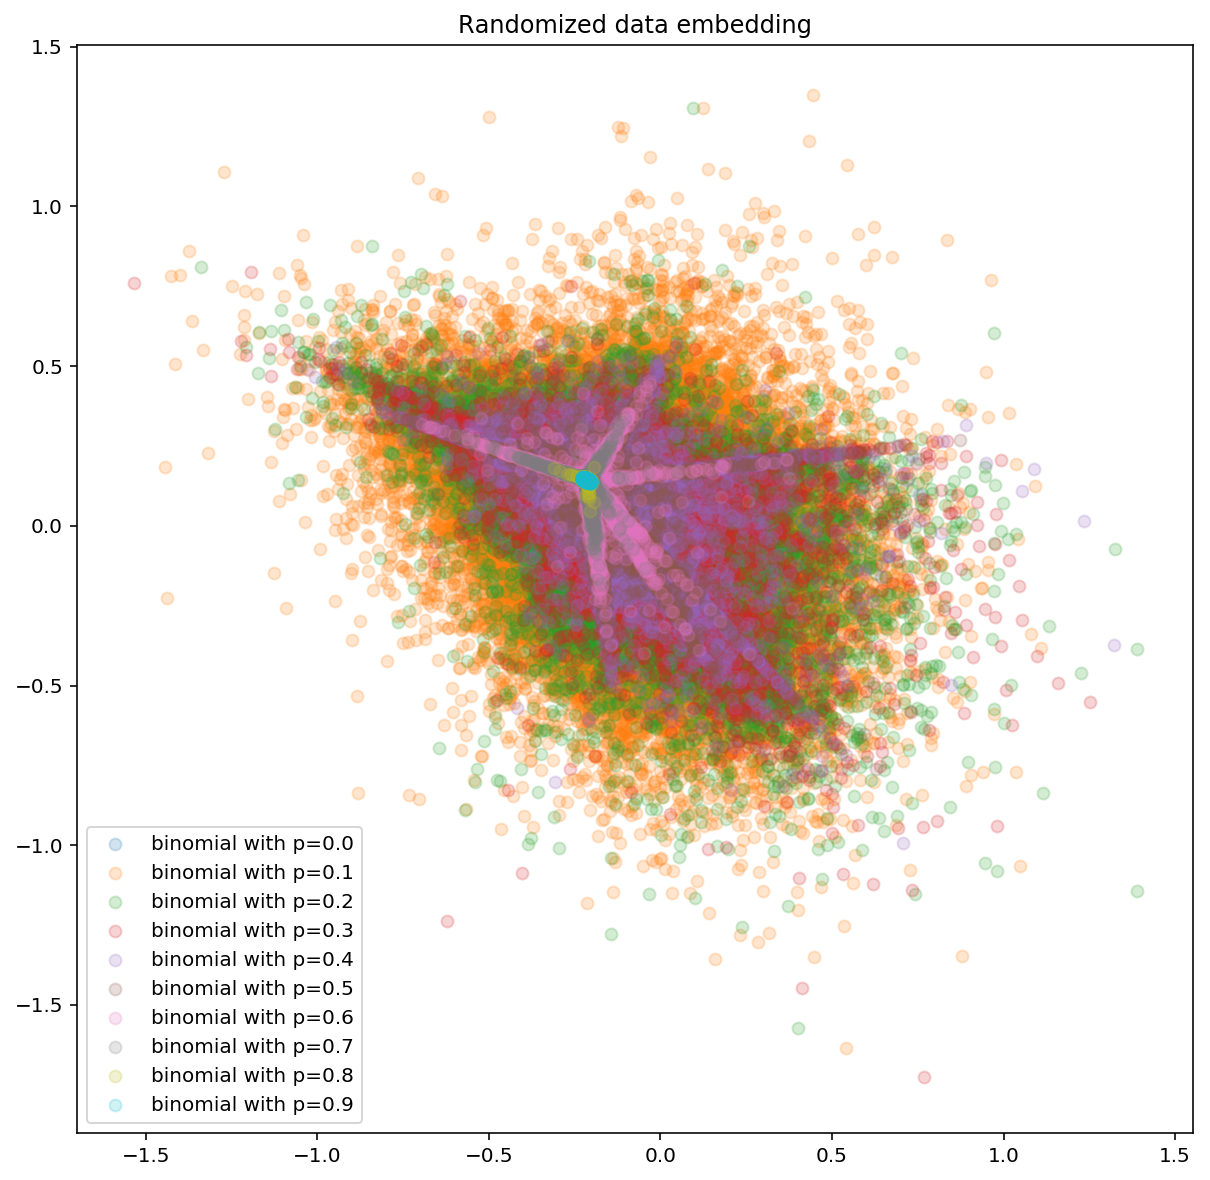

In [12]:
plt.figure(figsize=(10, 10))

# Generate stimulus response pairs
x_rand = []
y_rand = []
for p in np.arange(0, 1, 0.1):
    x_rand.append(np.random.binomial(1, p, (50000, 28, 28, 1)))
    y_rand.append(model_steal.predict(x_rand[-1]))
  
    plt.scatter(y_rand[-1][:, 0], 
                y_rand[-1][:, 1], 
                label='binomial with p={0:0.1f}'.format(p), 
                alpha=0.2)

x_rand = np.vstack(x_rand)
y_rand = np.vstack(y_rand)

plt.title("Randomized data embedding")
plt.legend()
plt.show()